### DATALOADER

In [6]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict


def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CompCar image directory.
	Returns:
		images: A dictionary with keys as car types and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each car type
	"""
	images = defaultdict(list)

	# Get the list of car type directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.jpg' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Car types: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt


Car types: ['Convertible', 'Minivan', 'Pickup', 'Sedan'] 

Convertible: 149 # of images
Minivan: 148 # of images
Pickup: 150 # of images
Sedan: 150 # of images
Shape of the images set is (200, 300)


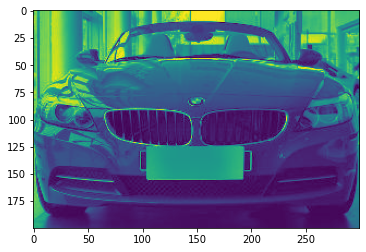

In [12]:
import matplotlib.pyplot as plt

images, cnt = load_data()
print("Shape of the images set is " + str(images['Convertible'][0].shape))
plt.imshow(images['Convertible'][0])
plt.show()

In [13]:
import numpy as np

def PCA(X,debug_mode=False):
	"""
	Args:
		X has shape Mxd where M is the number of images and d is the dimension of each image
	
	Returns:
		projected: projected data
		mean_image: mean of all images
		si: singular values
		vh: eigenvectors 
	"""

	mean_image = np.average(X, axis = 0)

	msd = X - mean_image # M x d

	smart_cov_matrix = np.matmul(msd, msd.T)
	eigen_values, smart_eigen_vectors = np.linalg.eig(smart_cov_matrix)

	idx = eigen_values.argsort()[::-1]   
	eigen_values = eigen_values[idx]
	smart_eigen_vectors = smart_eigen_vectors[:,idx]

	eigen_vectors = (np.matmul(msd.T, smart_eigen_vectors)).T # M x d

	row_norm = np.sum(np.abs(eigen_vectors)**2,axis=-1)**(1./2) # M

	normalized_eigen_vectors = eigen_vectors/(row_norm.reshape(-1, 1)) # M x d

	vh = normalized_eigen_vectors[:-1].T
	si = np.sqrt(eigen_values)[:-1]
    
	projected = np.matmul(msd, vh)/si

	return projected, mean_image, si, vh

In [26]:
dataset = []
maxVal = -1
for image in images['Convertible']:
    for pix_val in image.flatten():
        maxVal = max(maxVal, pix_val)  
print("Maximum value in the dataset is {}".format(maxVal))
for image in images['Convertible']:
    dataset.append(image.flatten()/maxVal)
dataset = np.array(dataset)
print("Shape of the dataset: " + str(dataset.shape))
#print("Length of dataset = {}".format(len(dataset)))
projections, _, singular_val, norm_vectors = PCA(dataset, True)
print("Shape of normalized vectors is {}".format(norm_vectors.shape))
print("The normalized vectors are {}".format(norm_vectors[0]))
print("The largest singular value is {}".format(singular_val[0]))

Maximum value in the dataset is 255
Shape of the dataset: (149, 60000)
Shape of normalized vectors is (60000, 148)
The normalized vectors are [-3.60615769e-04  8.71952283e-03 -2.80494491e-04  5.59483041e-05
  2.92634703e-03  4.39936958e-03  1.33513551e-03  2.73738146e-03
 -2.10016996e-04  1.00217442e-03  2.74673508e-03 -5.67194473e-04
  3.45136423e-03  1.36337327e-03  3.64605781e-03 -2.39140487e-03
 -4.98233834e-03 -6.45096803e-03 -7.19634574e-05 -6.65939016e-04
  5.61988152e-03 -1.22860021e-03 -4.18475372e-04 -7.79003905e-03
 -2.40742333e-03 -2.47084743e-03 -3.83648837e-03 -4.20633629e-03
 -1.10111666e-03  1.56575765e-02  9.67691934e-04 -3.36126601e-04
 -2.68902613e-03 -4.75186386e-04 -1.45271870e-05 -2.50119535e-03
  3.13424968e-05 -9.17814068e-05 -6.70802490e-04 -5.14589154e-03
  1.34467186e-04  3.29587352e-03  4.33383838e-03  4.94607750e-03
 -3.02666588e-03  7.77882819e-05 -9.08411624e-03  1.66482396e-04
 -1.36444190e-02 -6.36270059e-04  5.47719074e-03 -1.13937289e-03
 -4.69542303e

326.9946387897035

In [ ]:
def kFoldCrossValidation(K, images, carType='Minivan'):
    """ This function is used to implement K fold cross validation 
    
        Args - K    - Number for cross validation
             - data - List of all the images
    """
    # TODO: Whether a random shuffle of the dataset must be performed?
    assert(carType == 'Minivan' 
           or carType == 'Convertible' 
           or carType == 'Pickup' 
           or carType == 'Sedan')
    assert(K >= 2, "Value of K <= 2, won't run for K < 2")
    dataset = images[carType]
    #splits = [0, (K-2)*len(dataset)//K, (K-1)*len(dataset)//K, len(dataset)]
    splits = []
    for i in range(len(dataset)-K):
        splits.append(dataset[i:i+K])
    
    for fold in range(0, K):
        valSet, testSet = splits[(fold % K):(fold + 1 % K)], splits[((fold + 1)% K):((fold + 2) % K)]
        # There are three possibilities
        if(fold == 0):
            trainSet = splits[(fold%K):(fold + 1)%K]
        elif(fold == K-1):
            trainSet = splits[0:fold-2]
        else:
            trainSet = splits[0:((fold-1)%K)] + splits[(fold+2)%K:K]
    assert(len(trainSet == K-2), "Length of the training set isn't correct. Test kFoldCrossValidation again")
    assert(len(valSet == 1), "Length of the validation set isn't correct. Test kFoldCrossValidation again")
    assert(len(testSet == 1), "Length of the test set isn't correct. Test kFoldCrossValidation again")
    